In [1]:
## Import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import os, alive_progress
from alive_progress import alive_bar

from scipy.stats import mannwhitneyu as mwu
from utils import VD_A as vda
from utils import apfd
from utils import derive_data
from utils import sort_vda
from utils import calc_s12


# set inline print
%matplotlib inline

# Load CSV, calculate APFD and filter Equivalent==OK

In [2]:
df_fixed = derive_data(pd.merge(
                    pd.concat([pd.read_csv(os.path.join(path_log)) 
                               for path_log in ["k_1_k_2_hads_hsi_w_wp_fixed.csv", "k_1_k_2_spy_spyh.csv"]]), 
                    pd.read_csv(os.path.join("SUL_list.csv")),
                    how='left',on='SUL name'))
equiv_fixed=df_fixed.query(f'`Equivalent`=="OK" and `Extra States`==2').sort_values(by=['APFDx'],ascending=False)
equiv_fixed.EquivalenceOracle=equiv_fixed.EquivalenceOracle.str.replace(', 2, ',', ').replace('Soucha','')

df_random = derive_data(
                pd.merge(
                    pd.read_csv(os.path.join("random_logs.csv")), 
                    pd.read_csv(os.path.join("SUL_list.csv")),
                    how='left',on='SUL name')
)
equiv_random=df_random.query(f'`Equivalent`=="OK" and `Extra States`==2').sort_values(by=['APFDx'],ascending=False)
equiv_random.EquivalenceOracle=equiv_random.EquivalenceOracle.str.replace(', 2, ',', ').replace('Soucha','')

# Draw boxplots for TQ and APFDx

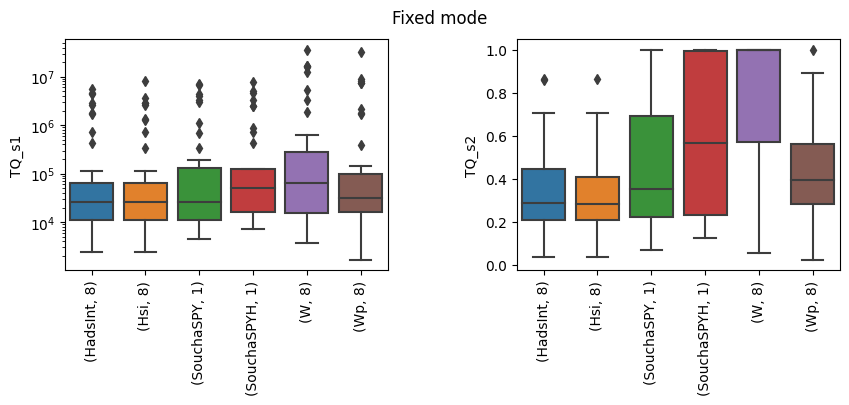

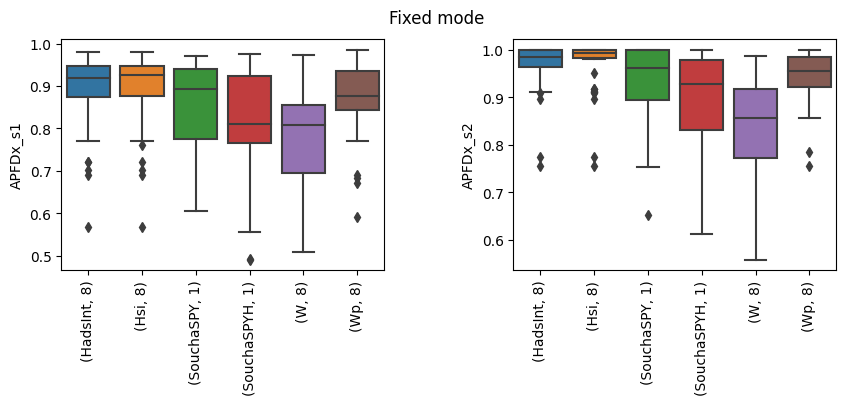

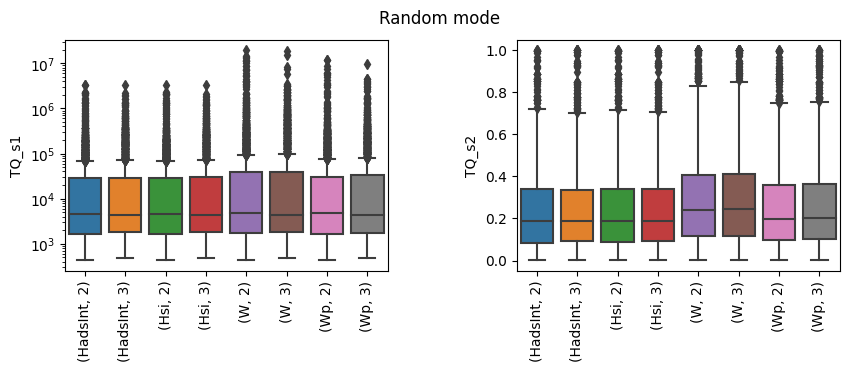

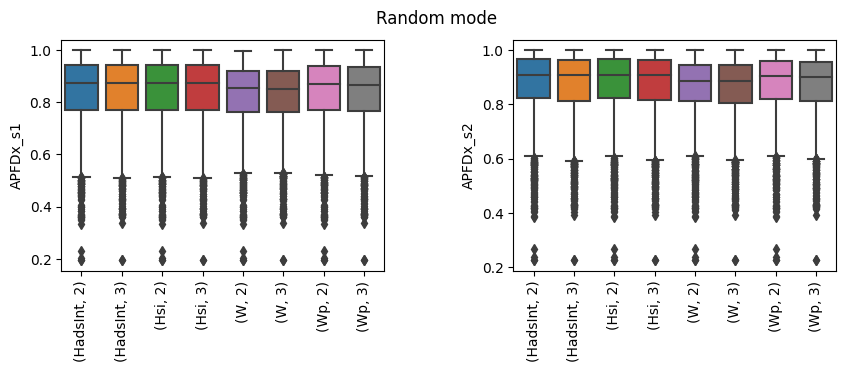

In [3]:
list_of_metrics = [['TQ_s1', 'TQ_s2'], ['APFDx_s1',  'APFDx_s2']]

for name,dataset in {'Fixed': equiv_fixed,'Random': equiv_random}.items():
    metrics_s12 = calc_s12(dataset).reset_index()
    for metrics_to_plot in list_of_metrics:
        # initialize figure with 2 subplots in a row
        fig, ax = plt.subplots(1, len(metrics_to_plot), figsize=(20*(len(metrics_to_plot)/4),3))

        # add padding between the subplots
        plt.subplots_adjust(wspace=0.4)

        idx=0
        for metric in metrics_to_plot:
            # draw plots
            sns.boxplot(data=metrics_s12, ax=ax[idx], x='EquivalenceOracle',y=metric)
            ax[idx].set_xlabel('')
            #ax[idx].set_xlim([0,1])
            ax[idx].tick_params(axis='x', rotation=90)
            if "_s1" in metric and not "APFDx_" in metric: ax[idx].set(yscale='log')
            idx=idx+1
        #add overall title to replot
        fig.suptitle(f'{name} mode')
        plt.show()

# Write tables for TQ and APFDx

In [4]:
for name,dataset in {'Fixed': equiv_fixed,'Random': equiv_random}.items():
    print(f'{name}')
    metrics_s12 = calc_s12(dataset).reset_index()
    for metrics_to_plot in list_of_metrics:
        for metric in metrics_to_plot:
            results=metrics_s12.sort_values(['SUL name','EquivalenceOracle'],ascending=True)\
                        .groupby(['EquivalenceOracle'])\
                        .apply(lambda x: x[metric].tolist())\
                        .reset_index()
            results=results.reindex(index=results.index[::-1])
            # importing combinations
            from itertools import product,combinations
            # apply combination method
            results = dict(zip(list(combinations(results['EquivalenceOracle'], 2)),list(combinations(results[0], 2))))
            results = pd.DataFrame.from_dict(results, orient='index').reset_index()
            results['mwu'] = results.apply(lambda x: mwu(x[0],x[1]).pvalue,axis=1)
            results['mwu<0.05'] = results['mwu']<0.05
            results[['vda_estimate','vda_magnitude']] = results.apply(lambda x: pd.Series(vda(x[0],x[1])),axis=1)
            results[['A','B']] = results['index'].apply(lambda x: pd.Series([x[0],x[1]]))
            results.drop([0,1,'index'],axis=1,inplace=True)
            results.set_index(['A','B'],inplace=True)
            results.columns.name = f'${metric.replace("_","_{")+"}"}$'
            with pd.option_context('display.float_format', '{:0.3f}'.format):
                display(results)

Fixed


$TQ_{s1}$                         mwu  mwu<0.05  vda_estimate vda_magnitude
A               B                                                          
(Wp, 8)         (W, 8)          0.136     False         0.409         small
                (SouchaSPYH, 1) 0.384     False         0.447    negligible
                (SouchaSPY, 1)  0.897     False         0.508    negligible
                (Hsi, 8)        0.388     False         0.552    negligible
                (HadsInt, 8)    0.419     False         0.549    negligible
(W, 8)          (SouchaSPYH, 1) 0.432     False         0.548    negligible
                (SouchaSPY, 1)  0.112     False         0.596         small
                (Hsi, 8)        0.021      True         0.640         small
                (HadsInt, 8)    0.024      True         0.636         small
(SouchaSPYH, 1) (SouchaSPY, 1)  0.384     False         0.553    negligible
                (Hsi, 8)        0.074     False         0.608         small
                (HadsInt, 8)    0.074     False         0.608         small
(SouchaSPY, 1)  (Hsi, 8)        0.410     False         0.550    negligible
                (HadsInt, 8)    0.446     False         0.546    negligible
(Hsi, 8)        (HadsInt, 8)    0.910     False         0.493    negligible

$TQ_{s2}$                         mwu  mwu<0.05  vda_estimate vda_magnitude
A               B                                                          
(Wp, 8)         (W, 8)          0.000      True         0.180         large
                (SouchaSPYH, 1) 0.175     False         0.418         small
                (SouchaSPY, 1)  0.524     False         0.539    negligible
                (Hsi, 8)        0.002      True         0.690        medium
                (HadsInt, 8)    0.006      True         0.665         small
(W, 8)          (SouchaSPYH, 1) 0.000      True         0.708        medium
                (SouchaSPY, 1)  0.000      True         0.805         large
                (Hsi, 8)        0.000      True         0.887         large
                (HadsInt, 8)    0.000      True         0.881         large
(SouchaSPYH, 1) (SouchaSPY, 1)  0.130     False         0.592         small
                (Hsi, 8)        0.000      True         0.712        medium
                (HadsInt, 8)    0.001      True         0.702        medium
(SouchaSPY, 1)  (Hsi, 8)        0.040      True         0.625         small
                (HadsInt, 8)    0.086     False         0.604         small
(Hsi, 8)        (HadsInt, 8)    0.716     False         0.478    negligible

$APFDx_{s1}$                      mwu  mwu<0.05  vda_estimate vda_magnitude
A               B                                                          
(Wp, 8)         (W, 8)          0.000      True         0.744         large
                (SouchaSPYH, 1) 0.073     False         0.609         small
                (SouchaSPY, 1)  0.922     False         0.506    negligible
                (Hsi, 8)        0.016      True         0.354         small
                (HadsInt, 8)    0.048      True         0.380         small
(W, 8)          (SouchaSPYH, 1) 0.133     False         0.409         small
                (SouchaSPY, 1)  0.002      True         0.308        medium
                (Hsi, 8)        0.000      True         0.197         large
                (HadsInt, 8)    0.000      True         0.213         large
(SouchaSPYH, 1) (SouchaSPY, 1)  0.159     False         0.414         small
                (Hsi, 8)        0.001      True         0.306        medium
                (HadsInt, 8)    0.004      True         0.326        medium
(SouchaSPY, 1)  (Hsi, 8)        0.049      True         0.381         small
                (HadsInt, 8)    0.105     False         0.402         small
(Hsi, 8)        (HadsInt, 8)    0.648     False         0.528    negligible

$APFDx_{s2}$                      mwu  mwu<0.05  vda_estimate vda_magnitude
A               B                                                          
(Wp, 8)         (W, 8)          0.000      True         0.810         large
                (SouchaSPYH, 1) 0.021      True         0.640         small
                (SouchaSPY, 1)  0.548     False         0.464    negligible
                (Hsi, 8)        0.001      True         0.299        medium
                (HadsInt, 8)    0.025      True         0.364         small
(W, 8)          (SouchaSPYH, 1) 0.014      True         0.351         small
                (SouchaSPY, 1)  0.000      True         0.231         large
                (Hsi, 8)        0.000      True         0.090         large
                (HadsInt, 8)    0.000      True         0.106         large
(SouchaSPYH, 1) (SouchaSPY, 1)  0.030      True         0.369         small
                (Hsi, 8)        0.000      True         0.206         large
                (HadsInt, 8)    0.000      True         0.249         large
(SouchaSPY, 1)  (Hsi, 8)        0.050      True         0.384         small
                (HadsInt, 8)    0.515     False         0.461    negligible
(Hsi, 8)        (HadsInt, 8)    0.080     False         0.605         small

Random


$TQ_{s1}$                   mwu  mwu<0.05  vda_estimate vda_magnitude
A            B                                                       
(Wp, 3)      (Wp, 2)      0.851     False         0.502    negligible
             (W, 3)       0.186     False         0.489    negligible
             (W, 2)       0.169     False         0.488    negligible
             (Hsi, 3)     0.402     False         0.507    negligible
             (Hsi, 2)     0.251     False         0.510    negligible
             (HadsInt, 3) 0.406     False         0.507    negligible
             (HadsInt, 2) 0.260     False         0.509    negligible
(Wp, 2)      (W, 3)       0.136     False         0.487    negligible
             (W, 2)       0.103     False         0.486    negligible
             (Hsi, 3)     0.478     False         0.506    negligible
             (Hsi, 2)     0.324     False         0.508    negligible
             (HadsInt, 3) 0.481     False         0.506    negligible
             (HadsInt, 2) 0.332     False         0.508    negligible
(W, 3)       (W, 2)       0.967     False         0.500    negligible
             (Hsi, 3)     0.031      True         0.518    negligible
             (Hsi, 2)     0.015      True         0.520    negligible
             (HadsInt, 3) 0.032      True         0.518    negligible
             (HadsInt, 2) 0.016      True         0.520    negligible
(W, 2)       (Hsi, 3)     0.024      True         0.519    negligible
             (Hsi, 2)     0.009      True         0.522    negligible
             (HadsInt, 3) 0.025      True         0.519    negligible
             (HadsInt, 2) 0.010      True         0.522    negligible
(Hsi, 3)     (Hsi, 2)     0.805     False         0.502    negligible
             (HadsInt, 3) 0.992     False         0.500    negligible
             (HadsInt, 2) 0.819     False         0.502    negligible
(Hsi, 2)     (HadsInt, 3) 0.801     False         0.498    negligible
             (HadsInt, 2) 0.984     False         0.500    negligible
(HadsInt, 3) (HadsInt, 2) 0.818     False         0.502    negligible

$TQ_{s2}$                   mwu  mwu<0.05  vda_estimate vda_magnitude
A            B                                                       
(Wp, 3)      (Wp, 2)      0.398     False         0.507    negligible
             (W, 3)       0.000      True         0.452    negligible
             (W, 2)       0.000      True         0.452    negligible
             (Hsi, 3)     0.001      True         0.527    negligible
             (Hsi, 2)     0.000      True         0.531    negligible
             (HadsInt, 3) 0.001      True         0.527    negligible
             (HadsInt, 2) 0.000      True         0.530    negligible
(Wp, 2)      (W, 3)       0.000      True         0.446    negligible
             (W, 2)       0.000      True         0.446    negligible
             (Hsi, 3)     0.016      True         0.520    negligible
             (Hsi, 2)     0.004      True         0.524    negligible
             (HadsInt, 3) 0.017      True         0.520    negligible
             (HadsInt, 2) 0.005      True         0.524    negligible
(W, 3)       (W, 2)       0.945     False         0.501    negligible
             (Hsi, 3)     0.000      True         0.575         small
             (Hsi, 2)     0.000      True         0.577         small
             (HadsInt, 3) 0.000      True         0.575         small
             (HadsInt, 2) 0.000      True         0.576         small
(W, 2)       (Hsi, 3)     0.000      True         0.575         small
             (Hsi, 2)     0.000      True         0.577         small
             (HadsInt, 3) 0.000      True         0.574         small
             (HadsInt, 2) 0.000      True         0.576         small
(Hsi, 3)     (Hsi, 2)     0.635     False         0.504    negligible
             (HadsInt, 3) 0.963     False         0.500    negligible
             (HadsInt, 2) 0.706     False         0.503    negligible
(Hsi, 2)     (HadsInt, 3) 0.609     False         0.496    negligible
             (HadsInt, 2) 0.922     False         0.499    negligible
(HadsInt, 3) (HadsInt, 2) 0.680     False         0.503    negligible

$APFDx_{s1}$                mwu  mwu<0.05  vda_estimate vda_magnitude
A            B                                                       
(Wp, 3)      (Wp, 2)      0.290     False         0.491    negligible
             (W, 3)       0.000      True         0.530    negligible
             (W, 2)       0.006      True         0.523    negligible
             (Hsi, 3)     0.071     False         0.485    negligible
             (Hsi, 2)     0.004      True         0.475    negligible
             (HadsInt, 3) 0.073     False         0.485    negligible
             (HadsInt, 2) 0.004      True         0.476    negligible
(Wp, 2)      (W, 3)       0.000      True         0.539    negligible
             (W, 2)       0.000      True         0.532    negligible
             (Hsi, 3)     0.439     False         0.493    negligible
             (Hsi, 2)     0.061     False         0.484    negligible
             (HadsInt, 3) 0.447     False         0.494    negligible
             (HadsInt, 2) 0.065     False         0.484    negligible
(W, 3)       (W, 2)       0.394     False         0.493    negligible
             (Hsi, 3)     0.000      True         0.456    negligible
             (Hsi, 2)     0.000      True         0.447    negligible
             (HadsInt, 3) 0.000      True         0.456    negligible
             (HadsInt, 2) 0.000      True         0.447    negligible
(W, 2)       (Hsi, 3)     0.000      True         0.462    negligible
             (Hsi, 2)     0.000      True         0.453    negligible
             (HadsInt, 3) 0.000      True         0.462    negligible
             (HadsInt, 2) 0.000      True         0.453    negligible
(Hsi, 3)     (Hsi, 2)     0.273     False         0.491    negligible
             (HadsInt, 3) 0.984     False         0.500    negligible
             (HadsInt, 2) 0.283     False         0.491    negligible
(Hsi, 2)     (HadsInt, 3) 0.268     False         0.509    negligible
             (HadsInt, 2) 0.974     False         0.500    negligible
(HadsInt, 3) (HadsInt, 2) 0.278     False         0.491    negligible

$APFDx_{s2}$                mwu  mwu<0.05  vda_estimate vda_magnitude
A            B                                                       
(Wp, 3)      (Wp, 2)      0.167     False         0.488    negligible
             (W, 3)       0.000      True         0.534    negligible
             (W, 2)       0.002      True         0.526    negligible
             (Hsi, 3)     0.024      True         0.481    negligible
             (Hsi, 2)     0.000      True         0.469    negligible
             (HadsInt, 3) 0.025      True         0.481    negligible
             (HadsInt, 2) 0.000      True         0.469    negligible
(Wp, 2)      (W, 3)       0.000      True         0.545    negligible
             (W, 2)       0.000      True         0.537    negligible
             (Hsi, 3)     0.378     False         0.493    negligible
             (Hsi, 2)     0.019      True         0.480    negligible
             (HadsInt, 3) 0.392     False         0.493    negligible
             (HadsInt, 2) 0.021      True         0.481    negligible
(W, 3)       (W, 2)       0.302     False         0.491    negligible
             (Hsi, 3)     0.000      True         0.448    negligible
             (Hsi, 2)     0.000      True         0.437    negligible
             (HadsInt, 3) 0.000      True         0.449    negligible
             (HadsInt, 2) 0.000      True         0.437    negligible
(W, 2)       (Hsi, 3)     0.000      True         0.456    negligible
             (Hsi, 2)     0.000      True         0.444    negligible
             (HadsInt, 3) 0.000      True         0.456    negligible
             (HadsInt, 2) 0.000      True         0.444    negligible
(Hsi, 3)     (Hsi, 2)     0.141     False         0.488    negligible
             (HadsInt, 3) 0.978     False         0.500    negligible
             (HadsInt, 2) 0.153     False         0.488    negligible
(Hsi, 2)     (HadsInt, 3) 0.134     False         0.513    negligible
             (HadsInt, 2) 0.958     False         0.500    negligible
(HadsInt, 3) (HadsInt, 2) 0.146     False         0.488    negligible

# Plot %states detected per test case (for all methods)

In [5]:
all_qtype = ['Testing symbols'] # alternative
all_runs = equiv_fixed[['SUL name', 'Seed']].drop_duplicates()
total = len(all_qtype)*len(all_runs)

# define figure size
sns.set(rc={'figure.figsize':(10,5),'figure.dpi':300})

os.makedirs(f'img/fixed_mode/', exist_ok=True)

with alive_bar(total, force_tty=True, title=f'Plotting APFD') as bar:
    for idx,row in all_runs.iterrows():
        # get an entry <SUL, seed>
        sulname,seed = row['SUL name'],row['Seed']
        subj=equiv_fixed.query(f'`SUL name`=="{sulname}"').copy()
        
        # add percent columns
        subj['HypSizePercent'] = subj['HypSize'].apply(lambda x: x/np.max(x)*100)

        # explode column with % of symbols and hypothesis sizes in the learning process
        subj=subj.explode(['HypSizePercent',*all_qtype])

        for qtype in all_qtype:
            #create line chart
            apfd_plot = sns.lineplot(subj, x=f'{qtype}', y='HypSizePercent',
                                     markers=True, 
                                     style='CTT', hue='CTT',
                                     palette='tab10'
                                    )
            apfd_plot.set(xscale='log')
            locator = ticker.LogLocator()
            locator.MAXTICKS = np.max(subj[f'{qtype}'])
            apfd_plot.xaxis.set_major_locator(locator)

            apfd_plot.yaxis.set_major_locator(ticker.MultipleLocator(10))
            apfd_plot.set_ylim(0,100)
            
            #add plot labels, titles and legends
            plt.xlabel(f'Number of {qtype.title()} (log scale)')
            plt.ylabel('Fraction of the SUL learned')
            plt.title(f'Subject: {sulname}')
            
            #get handles and labels
            handles, labels = plt.gca().get_legend_handles_labels()
            
            #specify order of items in legend from APFDx
            order = subj[['CTT','APFDx']].sort_values(['APFDx'],ascending=False).drop_duplicates().CTT.to_list()
            for idx,ctt in enumerate(order): order[idx]=labels.index(ctt)
            #add legend to plot
            plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
                       title='Testing Technique', loc='lower right', 
                       fontsize='xx-small', title_fontsize='xx-small')
            
            # save line chart
            fig = apfd_plot.get_figure()
            fname=sulname.replace('.dot','')
            fig.savefig(f'img/fixed_mode/cumsum_{fname}_{qtype}_{seed}.jpg')
            fig.clf()
            bar()

Plotting APFD |████████████████████████████████████████| 46/46 [100%] in 17.5s (2.61/s)                                 


<Figure size 3000x1500 with 0 Axes>